# imports

In [2]:
import datetime
import math
import os
import random
import time

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from scipy.optimize import OptimizeResult, brute, minimize, minimize_scalar
from tqdm.notebook import tqdm
from decouple import AutoConfig
from pathlib import Path
from math import ceil
import ray

from src.utils.profiles import generate_dep_Pax_Counters, show_up_function
from src.utils.profiles_from_schedule import (
    generate_dep_Pax_Counters as custom_generate_dep_Pax_Counters,
)

from src.simfunc.KIX_T1d import KIX_T1d, univariate_cost_function_generator_T1d_N
from src.simfunc.KIX_T1d_CUSBD import (
    KIX_T1d_CUSBD,
    univariate_cost_function_generator_T1d_CUSBD_N,
)

from src.simfunc.KIX_T1d_CUSBD import (
    cost_function_T1d_CUSBD_2var_modern_pax_ratio_CUSBD_opening_duration as cost_2_var,
)

from src.utils.optimizers import (
    custcallback,
    custmin,
    custmin_multicore,
    custcallback_multicore,
)
from src.utils.helpers import (
    calculate_EBS_LBC,
    calculate_avg_dwell_time,
    calculate_EBS_modern_pax_only,
)

/home/ubuntu/miniconda3/envs/KAPpaxsim2/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  warnings.warn(


In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

%load_ext autoreload
%autoreload 2

%load_ext nb_black

<IPython.core.display.Javascript object>

In [4]:
ray.shutdown()
ray.init()

2021-07-14 13:38:25,619	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '172.31.28.92',
 'raylet_ip_address': '172.31.28.92',
 'redis_address': '172.31.28.92:6379',
 'object_store_address': '/tmp/ray/session_2021-07-14_13-38-24_728733_13364/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-07-14_13-38-24_728733_13364/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-07-14_13-38-24_728733_13364',
 'metrics_export_port': 63354,
 'node_id': '6a41df0f226c36d90fad00170536bdf5c7cef1de7f72f561b1949108'}

<IPython.core.display.Javascript object>

## parameters import

In [5]:
# get the paths to config
root_path = Path(os.getcwd()) / "../../"
DOTENV_FILE_PATH = root_path / "data/secret/.env"
config = AutoConfig(search_path=DOTENV_FILE_PATH)
path_param = root_path / config("ADRM_param_full_path")

<IPython.core.display.Javascript object>

In [6]:
df_param_onedrive = pd.read_excel(
    path_param,
    sheet_name="Dynamic",
)

# generate df_set_param_T1d_from_drive from one drive excel file (assumptions all dept)
df_param_input = df_param_onedrive.set_index("item", drop=True, inplace=False)

# keep only T1 Int'l dep results
mask_T1d = (df_param_input["terminal"] == "T1") & (df_param_input["Direction"] == "D")
df_param_input_T1 = df_param_input[mask_T1d]

df_param_input_T1 = df_param_input_T1.drop(
    columns=["unit", "terminal", "type", "remarks", "Direction"]
)

# take values from assumption files and put them in a dictionnary
list_item = [
    "target_peak_STD",
    "Pt_checkin_1step_counter",
    "Pt_checkin_2step_counter",
    "N_kiosk",
    "Pt_kiosk",
    "N_security_lanes",
    "Pt_security_lanes",
    "N_emigration_counter",
    "Pt_emigration_counter",
    "N_emigration_self",
    "Pt_emigration_self",
    "modern_pax_ratio",
    "digital_pax_ratio",
    "premium_pax_ratio",
    "start_special_pax_ratio",
    "end_special_pax_ratio",
]

dct_set_param_T1d_from_drive = {
    item: list(df_param_input_T1.loc[item, :]) for item in list_item
}
len_dct_set_param_T1d_from_drive = len(dct_set_param_T1d_from_drive["target_peak_STD"])
dct_set_param_T1d_from_drive["target_peak"] = dct_set_param_T1d_from_drive.pop(
    "target_peak_STD"
)

# define values that are not in assumption files
dct_set_param_T1d_from_drive["freq"] = [
    "1min" for i in range(len_dct_set_param_T1d_from_drive)
]
dct_set_param_T1d_from_drive["win"] = [
    15 for i in range(len_dct_set_param_T1d_from_drive)
]
dct_set_param_T1d_from_drive["show_loading"] = [
    False for i in range(len_dct_set_param_T1d_from_drive)
]
dct_set_param_T1d_from_drive["show_graph"] = [
    False for i in range(len_dct_set_param_T1d_from_drive)
]
dct_set_param_T1d_from_drive["save_graph"] = [
    False for i in range(len_dct_set_param_T1d_from_drive)
]
dct_set_param_T1d_from_drive["save_xls"] = [
    False for i in range(len_dct_set_param_T1d_from_drive)
]

# change the start & end special pax, it was a bad idea
dct_set_param_T1d_from_drive["start_special_pax_ratio"] = [
    0 for i in range(len_dct_set_param_T1d_from_drive)
]

dct_set_param_T1d_from_drive["end_special_pax_ratio"] = [
    1 for i in range(len_dct_set_param_T1d_from_drive)
]

df_set_param_T1d_from_drive = pd.DataFrame.from_dict(dct_set_param_T1d_from_drive)

df_set_param_T1d = df_set_param_T1d_from_drive.copy()
dct_set_param_T1d = dct_set_param_T1d_from_drive.copy()

# create the dictionary of param for the run from the dct_set_param
# we take the values for 2025
dct_run_param = {keys: value[5] for keys, value in dct_set_param_T1d.items()}

<IPython.core.display.Javascript object>

## cost and grid_search def

In [7]:
def cost_generator(x, EBS_number, dct_run_param_T1d_2025):
    cost = cost_2_var(
        x=x,  # ['CUSBD_opening_duration' in minutes,'modern_pax_ratio']
        EBS_capacity=EBS_number,  # cost target
        target_wait_time=5,  # target waiting time in minutes
        dct_param_T1d=dct_run_param_T1d_2025,  # includes df_Pax
        target_peak=3880,  # to select good schedule when generating df_Counters
        custom_counter_rule=False,  # to generate df_Counters
        call_n_iter=None,
        totalpbar=None,
    )
    return cost


def grid_search(
    cost_generator,
    EBS_number,
    dct_run_param_T1d_2025,
    xmin=150,
    xmax=360,
    N_fev_x=7,
    ymin=0.05,
    ymax=0.99,
    N_fev_y=6,
    N_grid_search=2,
):
    # parameter ray for parallel computing
    @ray.remote
    def f(x, EBS_number=EBS_number):
        return cost_generator(
            x, EBS_number=EBS_number, dct_run_param_T1d_2025=dct_run_param_T1d_2025
        )

    # create dct of results
    dct_grid_search = {}

    for n in range(N_grid_search):
        # build grid_list
        x_range = list(np.linspace(xmin, xmax, N_fev_x))
        y_range = list(np.linspace(ymin, ymax, N_fev_y))
        grid_list = [(x, y) for y in y_range for x in x_range]

        # evaluate all points of the grid in parallel
        futures = [f.remote(i) for i in grid_list]
        results = ray.get(futures)

        # get the best point
        bestz = min(results)
        index = results.index(bestz)
        best_point = grid_list[index]
        bestx = best_point[0]
        besty = best_point[1]

        # build new ranges for next iteration's grid_list
        # new range on x
        if bestx != xmin:
            xmin = x_range[x_range.index(bestx) - 1]
        if bestx != xmax:
            xmax = x_range[x_range.index(bestx) + 1]

        # new range on y
        if besty != ymin:
            ymin = y_range[y_range.index(besty) - 1]
        if besty != ymax:
            ymax = y_range[y_range.index(besty) + 1]

        # store grid search results
        dct_grid_search[n] = [grid_list, results]

    return bestx, besty, bestz, dct_grid_search

<IPython.core.display.Javascript object>

### successive grid optimization

In [8]:
# calculate df_Pax
df_Pax_2025, _ = generate_dep_Pax_Counters(
    target_peak=3880,  # for quick test, real FY2025 value is 3880
    terminal="T1",
    custom_counter_rule=False,  # current allocation rule
)

# initialize dct_run_param
dct_run_param_T1d_2025 = dct_run_param.copy()

dct_run_param_T1d_2025["df_Pax"] = df_Pax_2025
dct_run_param_T1d_2025["N_kiosk"] = 99999  # we initialize with a lot of kiosk
dct_run_param_T1d_2025["digital_pax_ratio"] = 0  # we keep only modern pax
dct_run_param_T1d_2025["N_CUSBD"] = 24
dct_run_param_T1d_2025.pop("target_peak")
dct_run_param_T1d_2025["path"] = None

Pax and counter generation...: 100%|██████████| 2/2 [00:08<00:00,  4.33s/it]


<IPython.core.display.Javascript object>

In [9]:
# define ranges of parameters
CUSBD_number_range = [24, 48, 72]
EBS_number_range = [800, 1900]

# create df_result_opti
column_CUSBD_number = [a for a in CUSBD_number_range for b in EBS_number_range]
column_EBS_number = [a for b in CUSBD_number_range for a in EBS_number_range]
columns_list = [
    "CUSBD_number",
    "EBS_number",
    "N_Counter",
    "N_kiosk",
    "CUSBD_opening_duration",
    "modern_pax_ratio",
    "waiting_time_counters",
    "total_dep_process_time",
    "dwell_time",
]

df_result_opti = pd.DataFrame(columns=columns_list)
df_result_opti["CUSBD_number"] = column_CUSBD_number
df_result_opti["EBS_number"] = column_EBS_number

<IPython.core.display.Javascript object>

optimization for kiosk
loop #0:   bestx=25   besty=error=0.0002777777777777758 finished=True


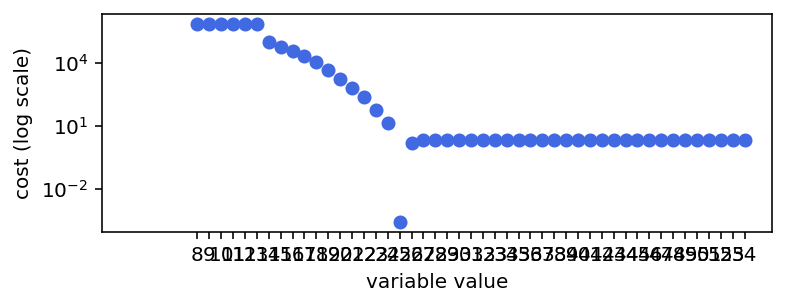

optimization for kiosk
loop #0:   bestx=25   besty=error=0.0002777777777777758 finished=True


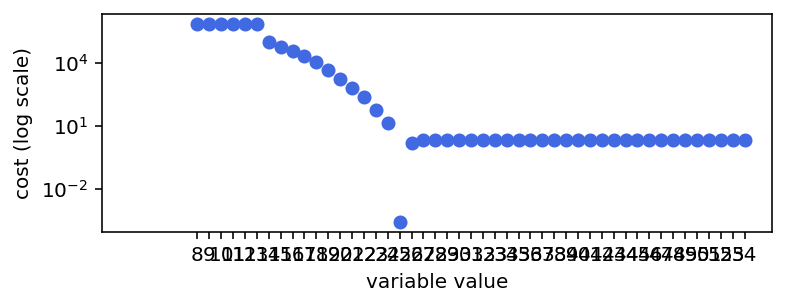

optimization for kiosk
loop #0:   bestx=42   besty=error=0.09000000000000002 finished=True


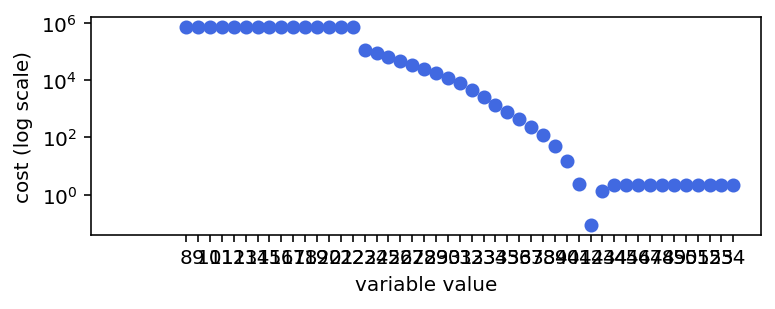

optimization for kiosk
loop #0:   bestx=46   besty=error=0.3802777777777778 finished=True


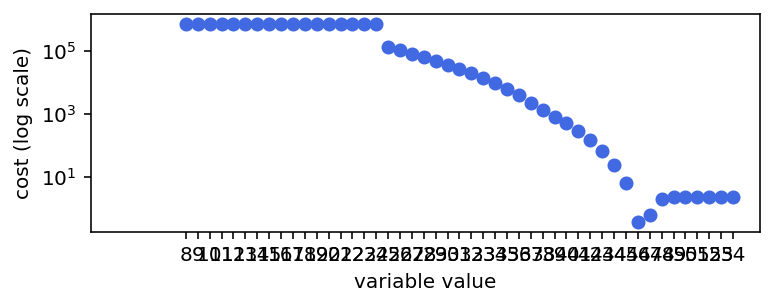

optimization for kiosk
loop #0:   bestx=54   besty=error=588.8711111111111 finished=False


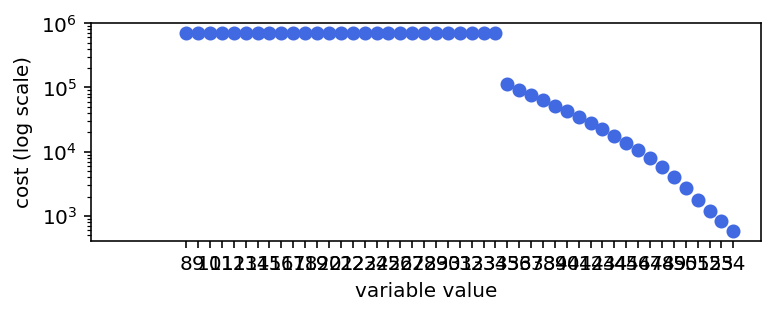

loop #1:   bestx=63   besty=error=0.10027777777777777 finished=True


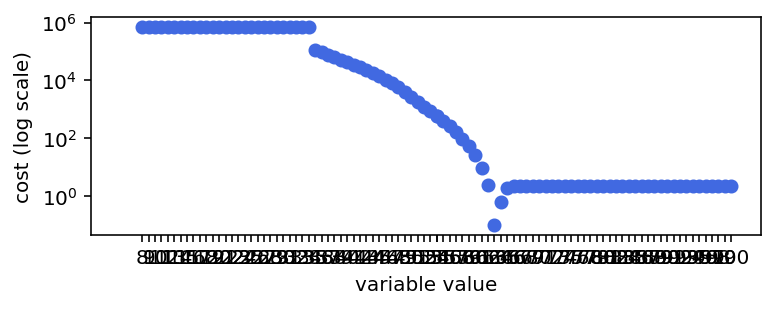

optimization for kiosk
loop #0:   bestx=54   besty=error=588.8711111111111 finished=False


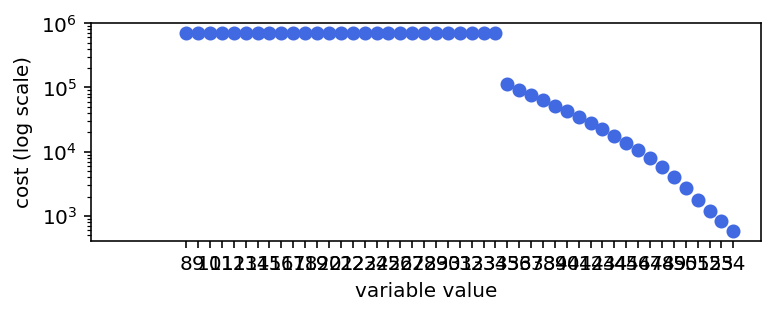

loop #1:   bestx=63   besty=error=0.10027777777777777 finished=True


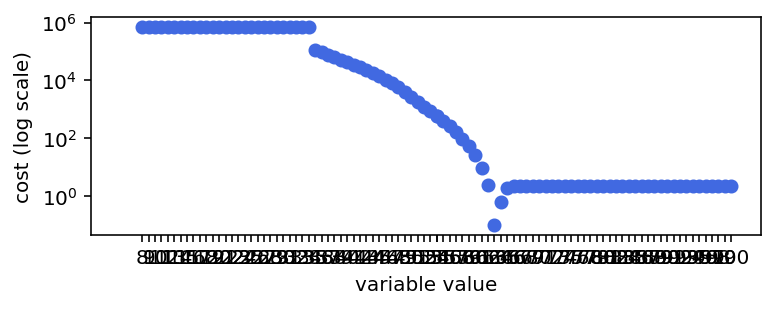

<IPython.core.display.Javascript object>

In [10]:
for CUSBD_number in CUSBD_number_range:
    for EBS_number in EBS_number_range:
        # initialize dct_param_opti
        dct_param_opti = dct_run_param_T1d_2025.copy()
        dct_param_opti["N_CUSBD"] = CUSBD_number
        dct_param_opti["N_kiosk"] = 99999  # we initialize with a lot of kiosk

        # optimize 'CUSBD_opening_duration' & 'modern_pax_ratio'
        (bestx, besty, bestz, dct_grid_search) = grid_search(
            cost_generator,
            EBS_number=EBS_number,
            dct_run_param_T1d_2025=dct_param_opti,
            xmin=150,
            xmax=360,
            N_fev_x=7,
            ymin=0.05,
            ymax=0.99,
            N_fev_y=6,
            N_grid_search=2,
        )

        dct_param_opti["CUSBD_opening_duration"] = bestx
        dct_param_opti["modern_pax_ratio"] = besty

        # optimize N_kiosk
        # allocation rule depending on modern_pax_ratio
        kwargs_rule = {
            "start_time": 3.5,
            "onecounter_time": 0.75,
            "base_n_counter": ceil(3 * (1 - besty)),
            "seats_per_add_counter": ceil(110 / (1 - besty)),
        }
        # generate df_Counter (only)
        df_Counters = show_up_function(
            target_peak=3880,
            direction="D",
            system="check-in",
            ratio=1,
            terminal="T1",
            CTG_type="A",
            custom_showup=False,
            custom_counter_rule=True,
            **kwargs_rule,
        )

        dct_param_opti["df_Counters"] = df_Counters

        # kwargs for the optimization of N_kiosk
        kwargs = {
            "dct_param_T1d": dct_param_opti,
            "variable_string": "N_kiosk",  # eg. N_Z, N_kiosk, N_CUSBD
            "target_wait_time": 1.5,  # target waiting time in minutes
            "call_n_iter": None,
            "totalpbar": None,
        }

        # options for custom optimizer
        options = {
            "guess": int(32),
            "N_core": 47,
            "callback": custcallback_multicore,
            "tol": 1,
        }

        # run the optimization for that variable
        print("optimization for kiosk")
        f = univariate_cost_function_generator_T1d_CUSBD_N(**kwargs)
        (
            bestx_kiosk,
            besty_kiosk,
            finished_kiosk,
            all_x_kiosk,
            all_y_kiosk,
        ) = custmin_multicore(f, **options)

        dct_param_opti["N_kiosk"] = bestx_kiosk

        # calculate wait time, total_dep_time and dwell_time

        (
            df_result,
            list_KPI_run,
            dct_hist_wait_time,
            dct_hist_queue_length,
        ) = KIX_T1d_CUSBD(**dct_param_opti)

        df_dwell, mean, top90 = calculate_avg_dwell_time(
            df_result,
            offset=pd.Timedelta(minutes=60),
        )

        # write results in dataframe

        mask = (df_result_opti["CUSBD_number"] == CUSBD_number) & (
            df_result_opti["EBS_number"] == EBS_number
        )

        df_result_opti.loc[mask, "waiting_time_counters"] = dct_hist_wait_time[
            "checkin_counter"
        ].quantile(q=0.9)
        df_result_opti.loc[mask, "dwell_time"] = mean

        df_result_opti.loc[mask, "CUSBD_opening_duration"] = bestx
        df_result_opti.loc[mask, "modern_pax_ratio"] = besty
        df_result_opti.loc[mask, "N_Counter"] = df_Counters['total'].max()
        df_result_opti.loc[mask,"N_kiosk"] = bestx_kiosk

In [11]:
path_report = root_path / "reports/202107_EBS_CUSBD_capacity_v4_start_1040pm.xlsx"

writer = pd.ExcelWriter(
    path_report,
    engine="xlsxwriter",
)
df_result_opti.to_excel(writer, sheet_name="results")
writer.save()

<IPython.core.display.Javascript object>

In [12]:
df_result_opti

,CUSBD_number,EBS_number,N_Counter,N_kiosk,CUSBD_opening_duration,modern_pax_ratio,waiting_time_counters,total_dep_process_time,dwell_time
0,24,800,103.0,25,196.666667,0.3884,19.633333,NaN,104.446872
1,24,1900,103.0,25,196.666667,0.3884,19.633333,NaN,104.446872
2,48,800,93.0,42,173.333333,0.6516,7.455,NaN,96.54741
3,48,1900,60.0,46,185.0,0.7268,13.883333,NaN,100.065685
4,72,800,56.0,63,173.333333,0.99,0.25,NaN,93.489051
5,72,1900,56.0,63,173.333333,0.99,0.25,NaN,93.489051


<IPython.core.display.Javascript object>